## Seminar 2. Linear models


<font color='red'>**Last updated: 30.01.2024**</font>

Let's start by downloading the necessary libraries and functions.

In [48]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt
import time
%matplotlib inline
# Fix the seed and the random state
seed=42
random_state=42

# 1. Supervised Learning

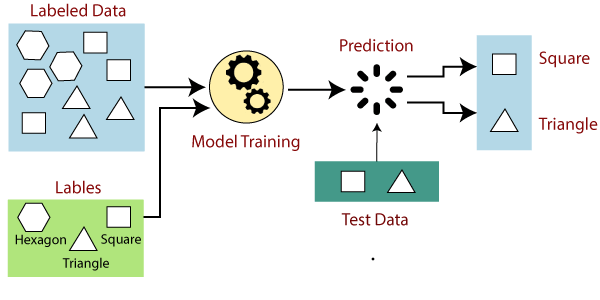

Let's begin by understanding the fundamental **fit-predict** paradigm common to many machine learning models.

In **supervised learning**, we work with a labeled dataset: $$(X,y) = \left\{(x_1, y_1), (x_2, y_2), ..., (x_N, y_N)\right\}.$$

*   $x_i \in \mathbb{X}$ are inputs (also known as **samples** or **objects**),
*   $y_i \in \mathbb{Y}$ are the corresponding outputs (**targets** or **labels**).


We aim to learn a model $f_{\theta} : \mathbb{X} \to \mathbb{Y}$ that accurately predicts the output $y$ for a given input $X$. This is achieved through an iterative process of model optimization.



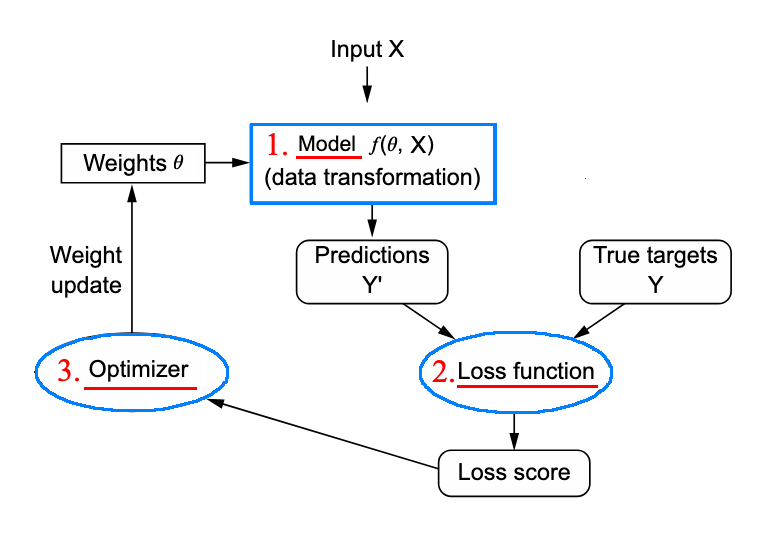


This process consists of:

1. Choosing a model  **model** $f_{\theta}(X)$, which is a function parameterized by $\theta$.
2. Defining a **loss function** $L(\hat{y}, y)$ that measures the difference between the model's predictions $\hat{y} = f_{\theta}(X)$ and the actual labels $y$.
3. Using an **optimization algorithm** to update the model parameters (weights) $\theta$  based on the loss $L$ in order to improve the model's predictions.

This cycle of evaluation and update is repeated until a satisfactory level of performance is achieved. Let's see how that works in practice.

## 1.1 **Dataset** =  what we are studying.


Supervised learning requires labeled data. Unlike other domains in ML that leverage existing datasets (e.g. MNIST, ImageNet, [Kaggle](https://www.kaggle.com/)), mathematical research often requires the creation of custom datasets from the ground up.

To illustrate this, let's create a dataset of (connected) planar graphs, including the number of vertices $V$, edges $E$, and faces $F$ for each graph.

*   <font color='blue'>**Question:**</font> How to generate *planar graphs*?

One method involves creating random graphs and verifying if they meet the criteria for planarity, as defined by [Kuratowski's theorem](https://en.wikipedia.org/wiki/Kuratowski%27s_theorem). This theorem states that a graph is non-planar if and only if it contains a subgraph  is a subdivision of the complete graph $K_5$  or the complete bipartite graph $K_{3,3}$.


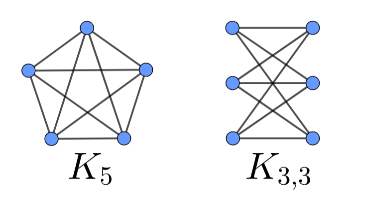

We employ a different strategy:

1. Start with a polygon on the plane.
2. In each step:
    * Select a random face of the graph.
    * Add a new internal point to this face.
    * Connect the new point to randomly selected vertices of the face.
    * Update the list of faces. Faces are represented by the order of their boundary vertices.


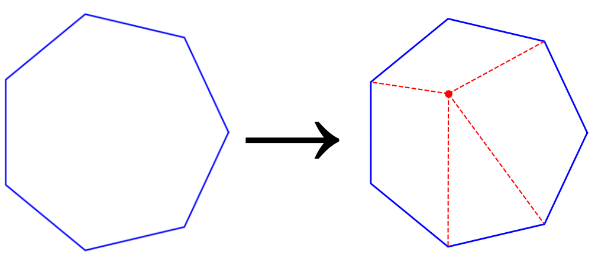

This method is easy to implement and allows control over the number of faces, although it may not generate all possible planar graphs.


### 1.1.1 Generation of planar graphs

The following function generates a planar graph with `max_vertices` vertices, starting with an initial polygon of `initial_vertices`.

In [49]:
def generate_planar_graph(max_vertices=4, initial_vertices=3):
    """Generates a planar graph by iteratively adding internal points to faces."""
    vertices = list(range(max_vertices))
    # Initial polygon has two faces
    initial_face = list()
    faces = [list(range(initial_vertices)), list(range(initial_vertices))]
    edges = [(i, i + 1) for i in range(initial_vertices-1)] + [(initial_vertices-1, 0)]
    # Choose the number of vertices
    for new_vertex in range(initial_vertices, max_vertices):
        # Select a random face
        face_index = np.random.randint(0,len(faces))
        face = faces[face_index]

        # Connect to randomly selected vertices of the face
        num_connections = np.random.randint(2,len(face)) #At least connect to 2 vertices
        connections = np.random.choice(face, size=num_connections, replace=False)
        for v in connections:
            edges.append((v, new_vertex))

        # Update faces
        for i in range(num_connections):
            start = connections[i]
            end = connections[(i+1)%num_connections]
            new_face = []
            idx = face.index(start)
            curr = start
            while curr != end:
                new_face.append(curr)
                idx = (idx+1)%len(face)
                curr = face[idx]
            new_face.append(end)
            new_face.append(new_vertex)
            # Add new faces, at the end replace the original face
            if i == num_connections - 1:
                faces[face_index] = new_face
            else:
                faces.append(new_face)
    return vertices, edges, faces

Let's visualize a generated graph in a simple case.

Vertices: [0, 1, 2, 3, 4, 5]
Edges: [(0, 1), (1, 2), (2, 0), (0, 3), (2, 3), (0, 4), (1, 4), (4, 5), (2, 5), (0, 5)]
Faces: [[2, 0, 3], [0, 4, 5], [0, 1, 2, 3], [0, 1, 4], [4, 1, 2, 5], [2, 0, 5]]


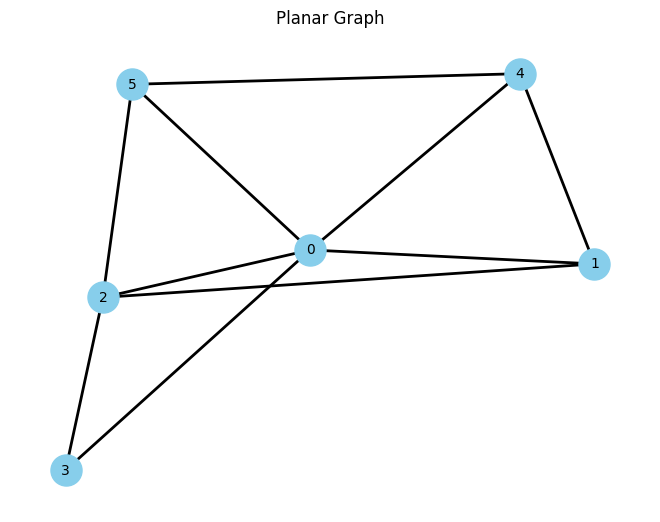

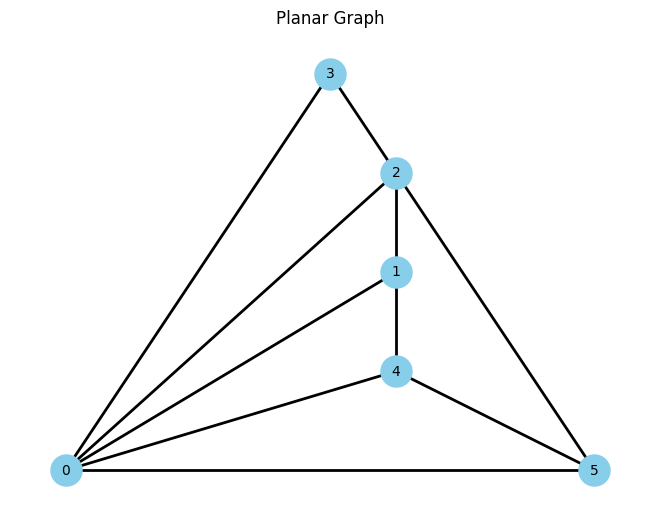

In [51]:
import networkx as nx

vertices, edges, faces = generate_planar_graph(max_vertices=6, initial_vertices=3)
print("Vertices:", vertices)
print("Edges:", edges)
print("Faces:", faces)

def draw_planar_graph(vertices, edges, faces):
    """Draws a planar graph using networkx and matplotlib."""
    graph = nx.Graph()
    graph.add_nodes_from(vertices)
    graph.add_edges_from(edges)

    pos1 = nx.spring_layout(graph)  # You can try other layout algorithms if needed.
    pos2 = nx.planar_layout(graph)

    nx.draw(graph, pos1, with_labels=True, node_color="skyblue", node_size=500, font_size=10, font_color="black", width=2)
    plt.title("Planar Graph")
    plt.show()

    nx.draw(graph, pos2, with_labels=True, node_color="skyblue", node_size=500, font_size=10, font_color="black", width=2)
    plt.title("Planar Graph")
    plt.show()

draw_planar_graph(vertices, edges, faces)

### 1.1.2 Dataset of planar graphs

Let's generate a dataset of 5,000 planar graphs, each with a maximum of 100 vertices. The presence of duplicate graphs within the dataset is not a concern for our purpose.

In [54]:
from tqdm import tqdm

num_graphs = 5000
max_vertices = 100

df = []
#for i in range(num_graphs):
for i in tqdm(range(num_graphs)):
  num_vertices = np.random.randint(3, max_vertices+1)
  vertices, edges, faces = generate_planar_graph(num_vertices)
  df.append([len(vertices), len(edges), len(faces)])

df = pd.DataFrame(df, columns=['Vertices', 'Edges', 'Faces'])
df.head()

100%|██████████| 5000/5000 [00:10<00:00, 474.88it/s]


Vertices  Edges  Faces
0         8     13      7
1        19     42     25
2        20     43     25
3        28     63     37
4        67    160     95

A useful command  to obtain basic Pandas DataFrame statistics:

In [55]:
df.describe()

Vertices        Edges        Faces
count  5000.0000  5000.000000  5000.000000
mean     51.6446   124.221200    74.576600
std      28.5595    73.100338    44.814638
min       3.0000     3.000000     2.000000
25%      27.0000    60.000000    35.000000
50%      52.0000   124.000000    74.000000
75%      77.0000   188.000000   113.000000
max     100.0000   304.000000   206.000000

Let's visualize the distribution of vertices and edges.

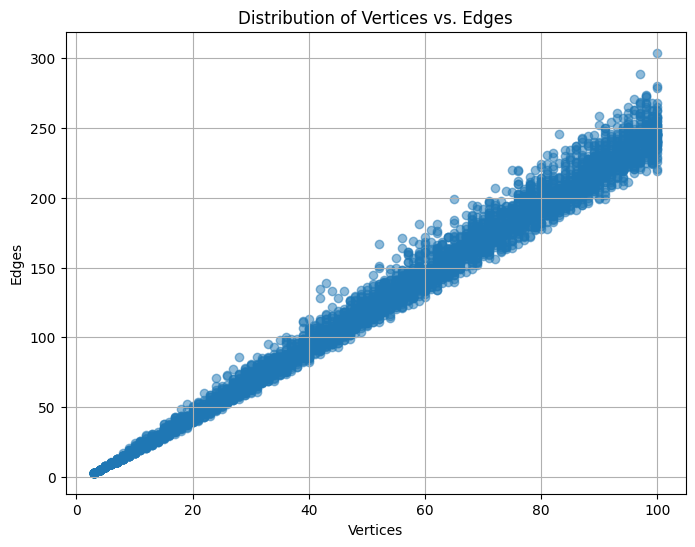

In [56]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Vertices'], df['Edges'], alpha=0.5)
plt.xlabel('Vertices')
plt.ylabel('Edges')
plt.title('Distribution of Vertices vs. Edges')
plt.grid(True)
plt.show()

### 1.1.3 Features and targets

We now aim to predict the number of faces for each graph.

*   The columns with vertices and edges represent the **object x_i**.
*   The column with faces is the **target y_i**.

In practice we represent the objects and targets as a **feature matrix** $X$ and a **target matrix** $Y$:

 $$X = \left( \begin{matrix} x_{1,1} & \dots & x_{1, D} \\ x_{2, 1} & \dots & x_{2, D} \\ \vdots & \ddots & \vdots \\  x_{N,1} & \dots & x_{N, D}  \end{matrix} \right), \qquad Y = \left( \begin{matrix} y_{1} \\  y_{2} \\ \vdots \\ y_{N}  \end{matrix} \right).$$

In general, $X$ has more than $1$ column.

*   In **regression problems** the targets are real values $y_i \in \mathbb{R}$.
*   In **classification problems** the targets belong to a finite set $y_i \in \left\{0, 1, \dots, K \right\}$.  

Below we consider the regression problem.

In [57]:
# split into input and output columns
X, y = df.values[:, :-1], df.values[:, -1]
print(X.shape, y.shape)

(5000, 2) (5000,)


Generating labeled datasets in Mathematics can be quite challenging.  Consider, for instance:

*   <font color='blue'>**Question (for discussion):**</font> How to find the *genus $\gamma(G)$ of a graph $G$*?  The genus $g=\gamma(G)$ is the minimum integer $g$ such that $G$ can be embedded on an orientable surface of genus $g$ without any edge crossings.

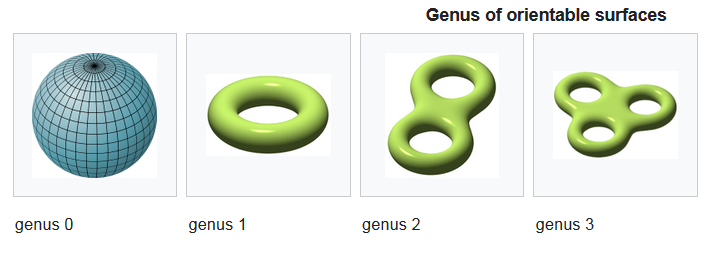

### 1.2 Train-test split

We divide the dataset into 2 part. Imagine preparing for an exam.

1.  The **train** dataset.

First, our ML model knows the right answer (=target) and tries to <font color='red'>**fit**</font>  them.

2.  The **test** dataset.

Next, the "exam" comes. Our ML model doesn't know the right answer and need to <font color='red'>**predict**</font> them correctly.


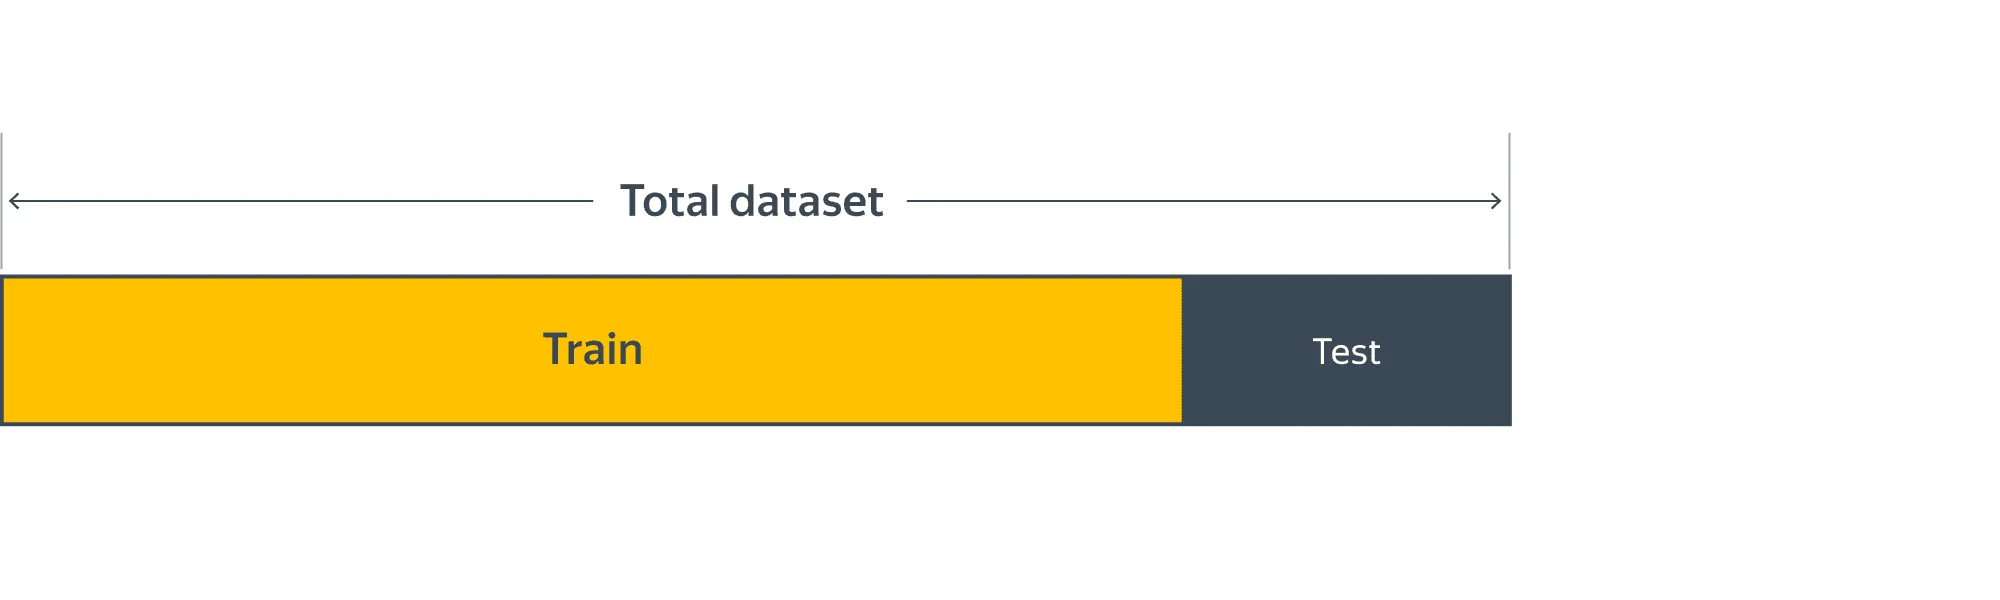


We use standard tools, such as train-test split functions, to divide the dataset:

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4000, 2) (1000, 2) (4000,) (1000,)



*   <font color='blue'>**Question:**</font> Since we did not remove duplicates, some elements may appear in both the Train and Test sets. Is it a bad thing?

Yes, it is a data leakage.

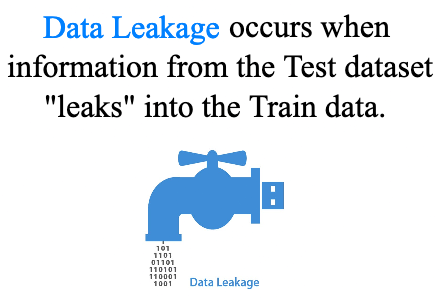

In this toy dataset, elements are relatively distinct.

   > However, the primary goal of machine learning is to enable models to **learn generalizable patterns** within the data, **not merely memorize** specific instances.

It is crucial to <font color='red'>**avoid Data Leakage!**</font> It can lead to overly optimistic performance metrics and poor model generalization.


*   <font color='blue'>**Question (for discussion):**</font> How can data leakage happen when working with mathematical datasets?"

**Hint**: consider sequential data (e.g. number sequences).

# 1.2 ML model

We need to choose some class of functions $F$ for our predictions. https://scikit-learn.org is the famous zoo of basic ML models.

*    **[Linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)** is a good baseline for regression problems.

In Linear Regression, we model the relationship between the input features $x_i$ and the output using a linear function: $$f_w(x_i) = \langle w, x_i \rangle + w_0 = w_1 x_1 + \dots + w_D x_D + w_0.$$

Here

*   $w = (w_1, \dots, w_D)$ is the **weight vector**,
*   $w_0$ is the **intercept** (or **bias**).


In [59]:
from sklearn.linear_model import LinearRegression
# Use fit_intercept=False for centered data
reg =  LinearRegression()

# 1.3 Loss function

What is a good prediction? In practice we minimize some **loss function** $$\theta_0 = \arg\min_{\theta} L(F_{\theta}(x), y).$$


*   Standard **Linear Regression** minimizes [MSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html): $$ \text{MSE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2.$$
* Another popular loss for regression is [MAE](https://scikit-learn.org/1.5/modules/model_evaluation.html#mean-absolute-error): $$ \text{MAE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} \left| y_i - \hat{y}_i \right|.$$

MAE is more robust to outliers (objects with big features) than MSE.




In [60]:
# MSE loss
from sklearn.metrics import mean_squared_error

#1.4 Let's  fit-predict

The "fit step" is a one-liner:

In [61]:
# fit the model
reg.fit(X_train, y_train)

LinearRegression()

The "predict step" is trivial, as always:

In [62]:
# predictions of the model
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred)

8.62942832830317e-28

We can take a look at **the coefficients and intercept**:

In [63]:
print('Coefficients:', reg.coef_)
print('Intercept:', reg.intercept_)

Coefficients: [-1.  1.]
Intercept: 2.0000000000000426


We knew the answer from the very beggining:

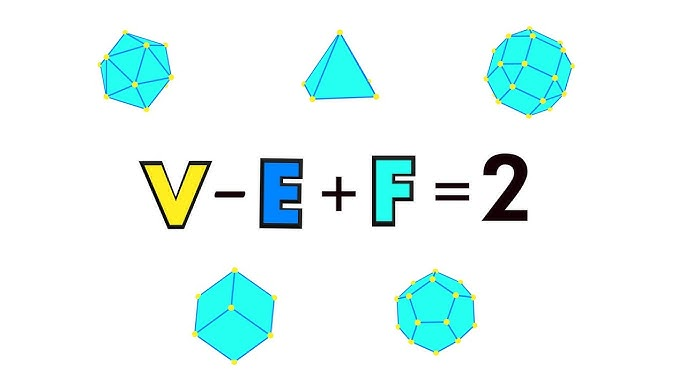

# 2. Mathematics of Linear Regression

Let's generate synthetic data and then train a linear regression model on it.

(70, 1) (30, 1) (70, 1) (30, 1)


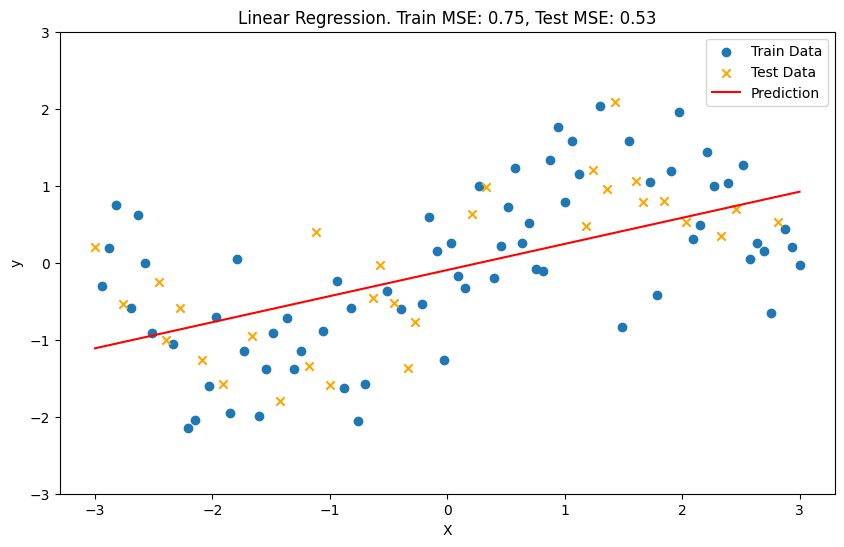

In [65]:
np.random.seed(42)
X = np.linspace(-3, 3, 100).reshape(-1, 1)
y = np.sin(X) + np.random.normal(0, 0.7, 100).reshape(-1, 1) # Increased noise for better visualization
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


# Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions and MSE calculation
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)
X_plot = np.linspace(-3, 3, 100)
y_pred = lin_reg.predict(X_plot.reshape(-1, 1))

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, label="Train Data")
plt.scatter(X_test, y_test, label="Test Data", marker='x', color='orange')
plt.plot(X_plot, y_pred, color='red', label="Prediction")
plt.xlabel("X")
plt.ylabel("y")
plt.title(f"Linear Regression. Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
plt.legend()
plt.ylim(-3, 3) #Consistent y-axis for comparison
plt.show()

Linear regression admits an analytical (or closed-form) solution: $$w = \left(X^T X\right)^{-1}X^T y.$$ Note that the intercept $w_0$ is absent in this formula. We can account for the intercept $w_0$ by extending each input vector $x_i$ with a constant feature of $1$: $$(x_1, \dots, x_D) \cdot \left(\begin{matrix} w_1 \\ \dots \\ w_D \end{matrix} \right) + w_0 = (1,  x_1, \dots, x_D) \cdot \left(\begin{matrix} w_0 \\ w_1 \\ \dots \\ w_D \end{matrix} \right).$$ Let's check this analytical solution.


In [66]:
# Add a bias term to the input features
X_train_b = np.c_[np.ones((len(X_train), 1)), X_train]

# Calculate the weights using the normal equation
w_exact = np.linalg.inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train

# Compare with the sklearn model's weights
print("Weights from sklearn:")
print(lin_reg.intercept_, lin_reg.coef_[0])

print("\nWeights from the normal equation:")
print(w_exact[0], w_exact[1])

# Make predictions using the exact solution
X_test_b = np.c_[np.ones((len(X_test), 1)), X_test]
y_test_pred_exact = X_test_b @ w_exact

# Calculate the mean squared error for the exact solution
test_mse_exact = mean_squared_error(y_test, y_test_pred_exact)

print("\nTest MSE from sklearn:", test_mse)
print("Test MSE from exact solution:", test_mse_exact)

#Check if the solutions are close
print("\nAre the solutions close?", np.allclose(y_test_pred, y_test_pred_exact))

Weights from sklearn:
[-0.09472418] [0.33897727]

Weights from the normal equation:
[-0.09472418] [0.33897727]

Test MSE from sklearn: 0.5262558479268773
Test MSE from exact solution: 0.5262558479268773

Are the solutions close? True


# 3. Overfitting and underfitting

Time and time again, in ML we will encounter the following pattern:

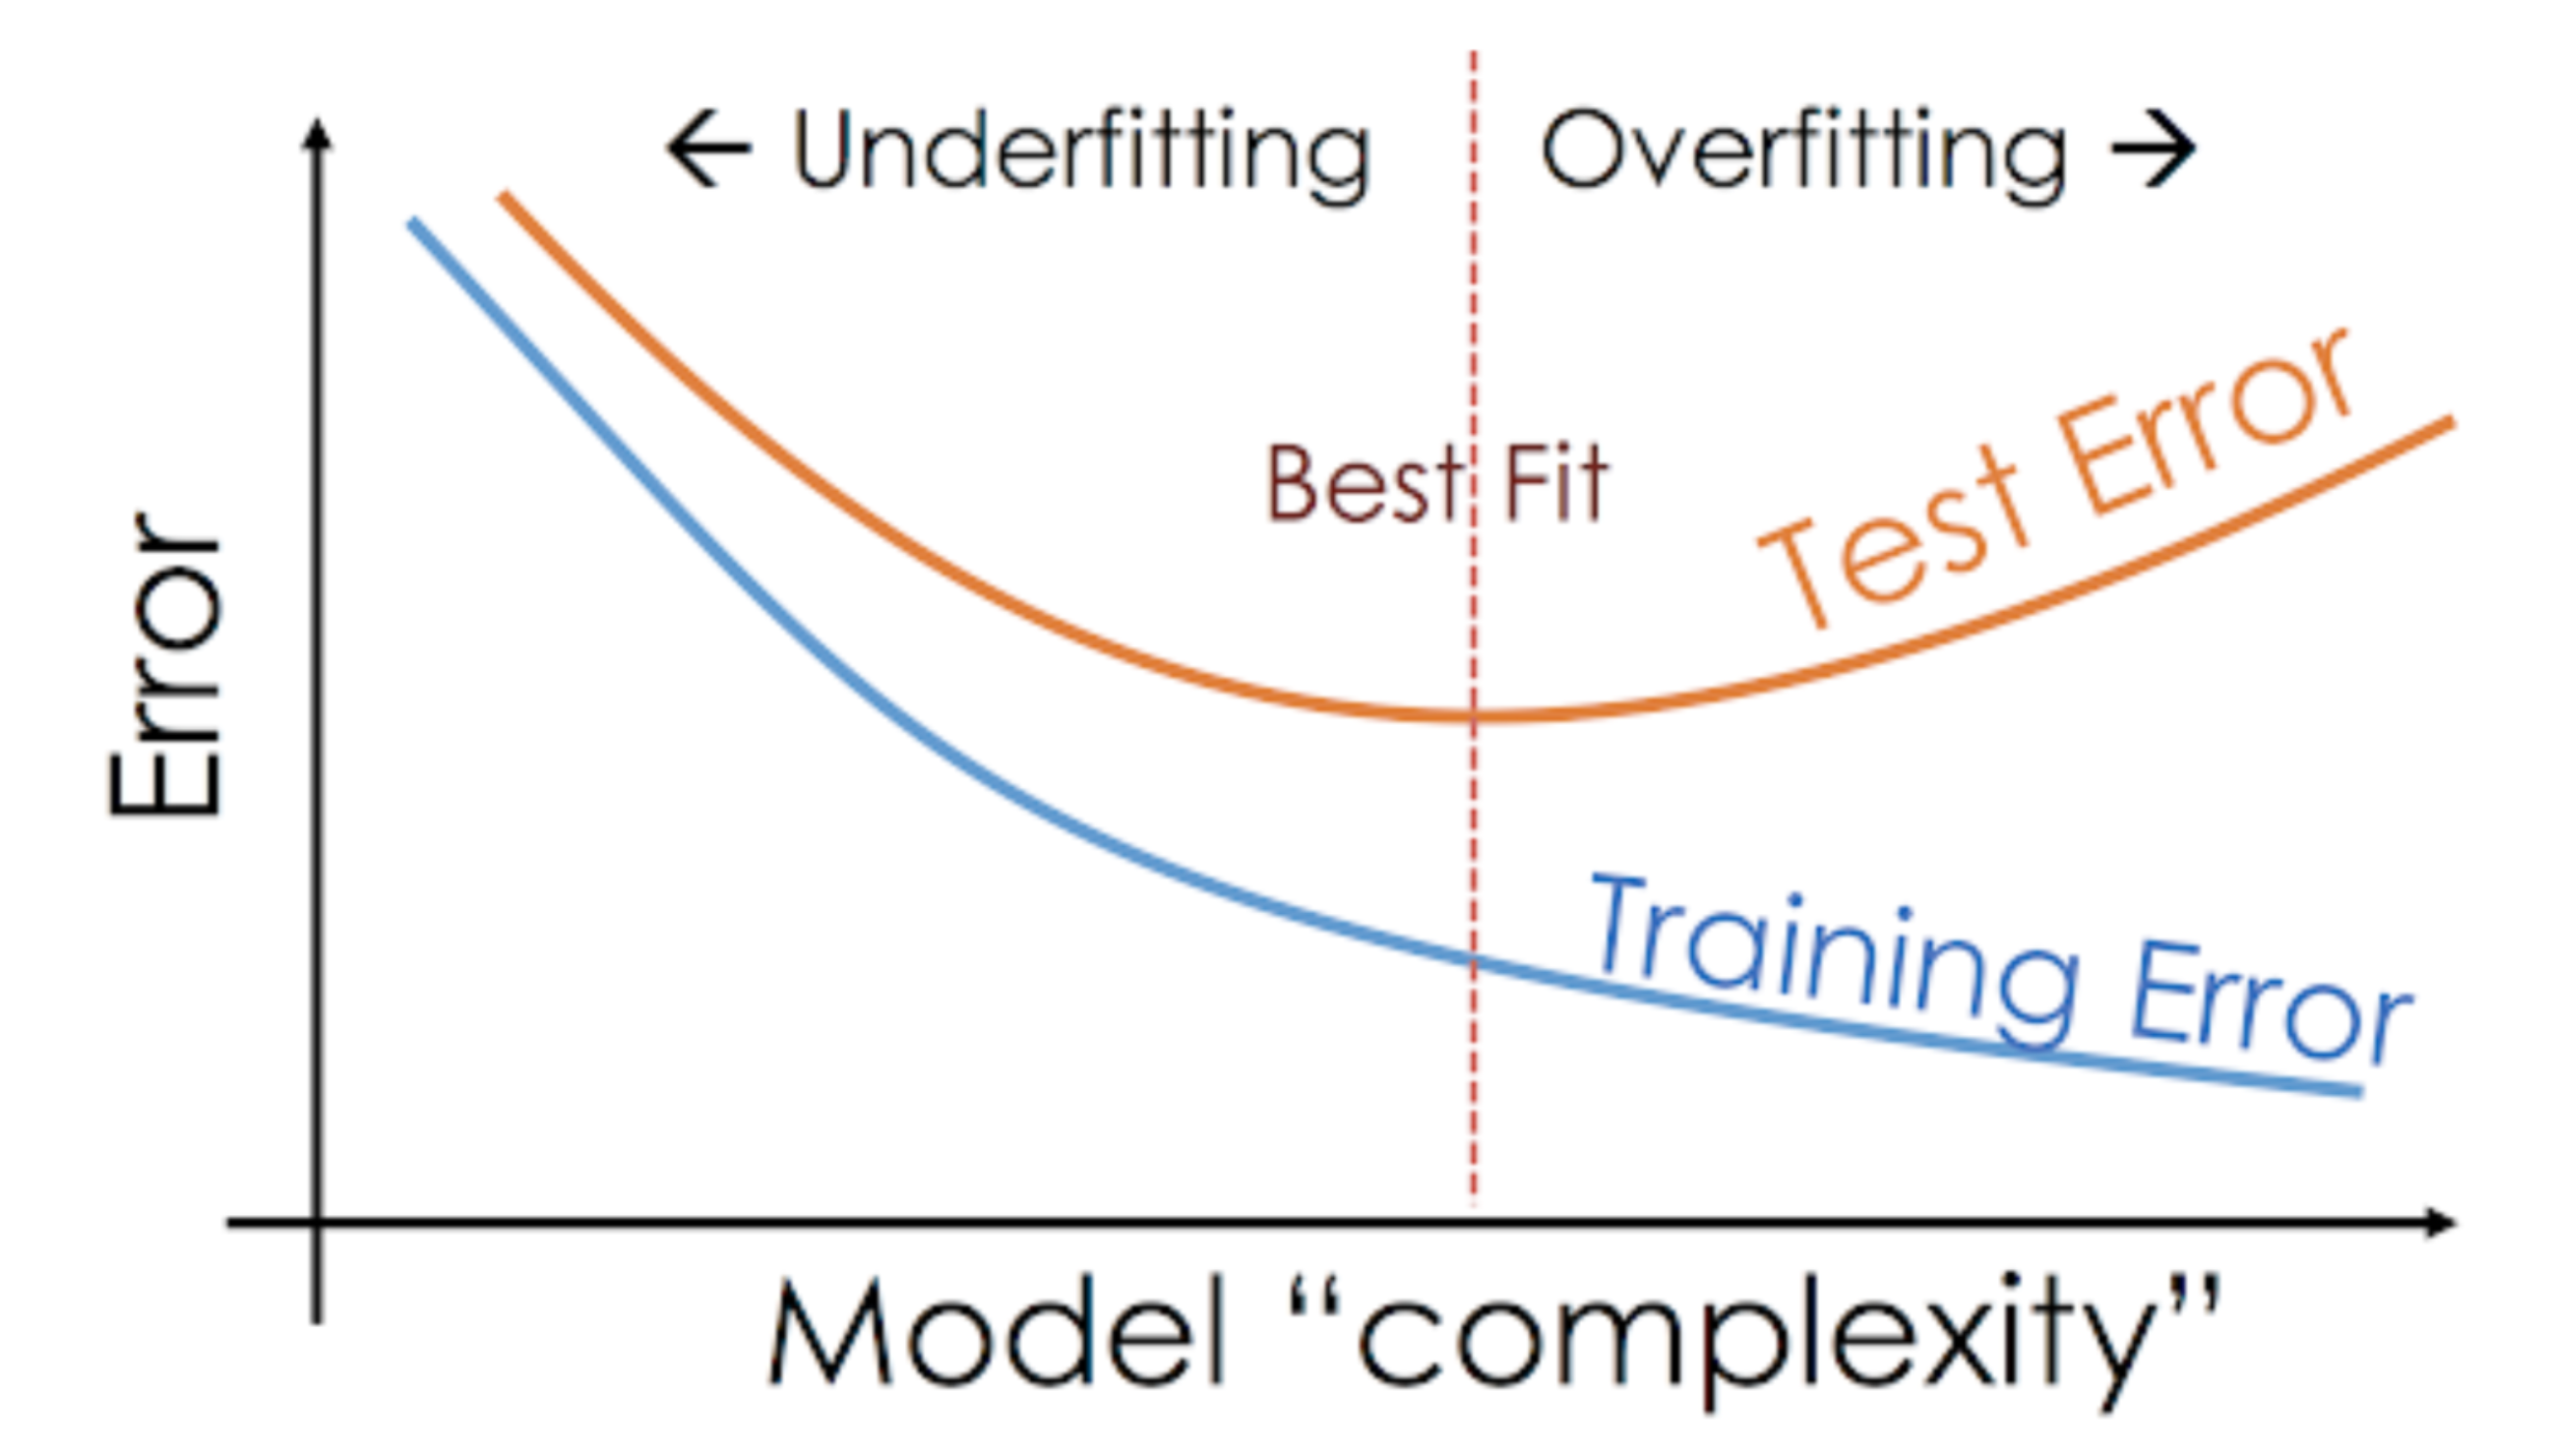

While linear regression is a straightforward model, its performance can be enhanced by incorporating additional features. We now consider polynomial regression, which approximates the data using polynomial functions: $$f(x) = a_0 + a_1 x + a_2 x^2 + \dots + a_D x^D.$$ We will examine the resulting training and test scores.

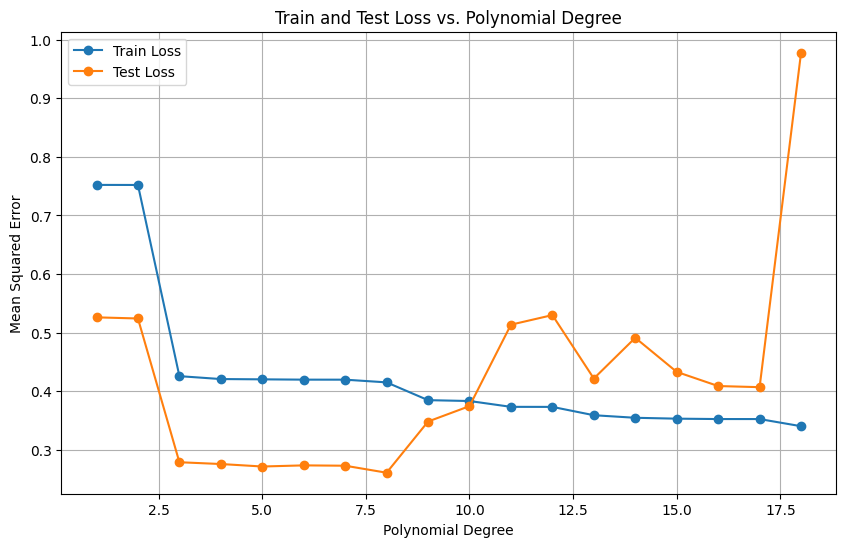

In [67]:
from sklearn.preprocessing import PolynomialFeatures

train_losses = []
test_losses = []
degrees = range(1, 19)

for degree in degrees:
    # Polynomial features
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly_train = poly_features.fit_transform(X_train)
    X_poly_test = poly_features.transform(X_test)

    # Linear Regression model
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly_train, y_train)

    # Predictions and MSE calculation
    y_train_pred = lin_reg.predict(X_poly_train)
    y_test_pred = lin_reg.predict(X_poly_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_losses.append(train_mse)
    test_losses.append(test_mse)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_losses, label="Train Loss", marker='o', linestyle='-')
plt.plot(degrees, test_losses, label="Test Loss", marker='o', linestyle='-')
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error")
plt.title("Train and Test Loss vs. Polynomial Degree")
plt.legend()
plt.grid(True)
plt.show()

Let's look at the underfitting and overfitting models.

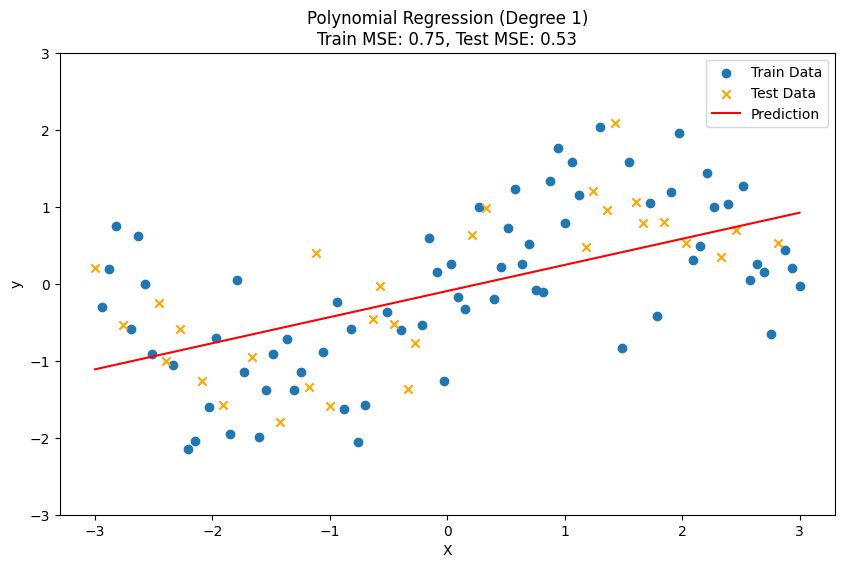

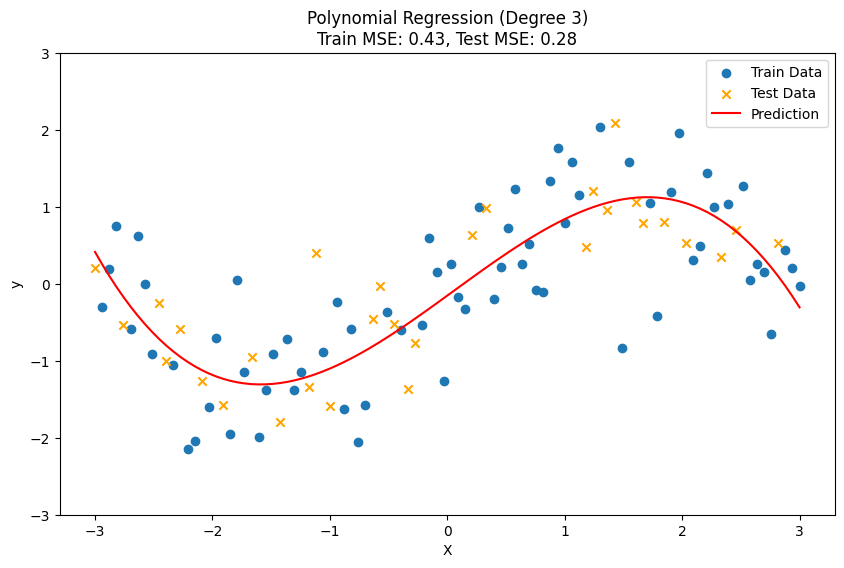

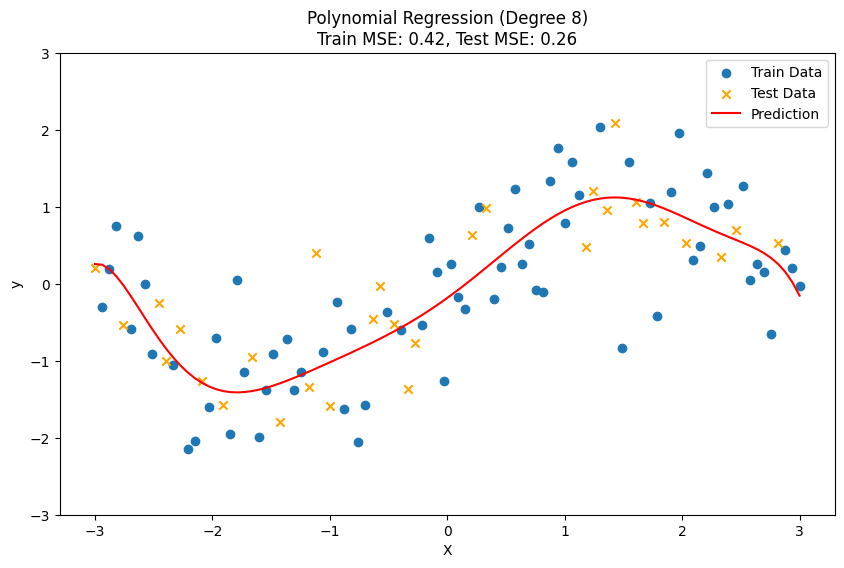

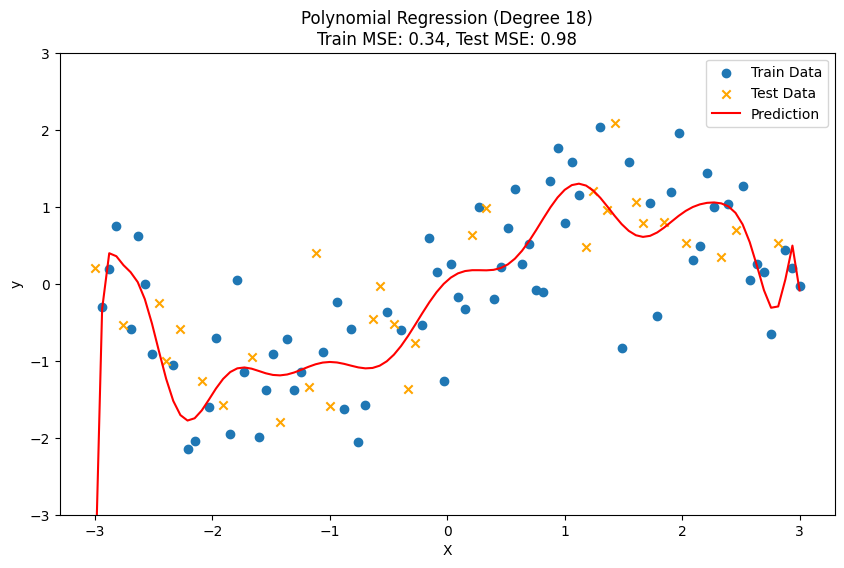

In [68]:
def plot_predictions(X_train,y_train,X_test,y_test, X_plot, y_pred, title, train_mse, test_mse):
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, y_train, label="Train Data")
    plt.scatter(X_test, y_test, label="Test Data", marker='x', color='orange')
    plt.plot(X_plot, y_pred, color='red', label="Prediction")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.title(f"{title}\nTrain MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
    plt.legend()
    plt.ylim(-3, 3) #Consistent y-axis for comparison
    plt.show()

def fit_polynomial(model, degrees, title = ""):
    for degree in degrees:
        # Polynomial features
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly_train = poly_features.fit_transform(X_train)
        X_poly_test = poly_features.transform(X_test)
        X_poly_plot = poly_features.transform(np.linspace(-3, 3, 100).reshape(-1, 1)) # For plotting smooth curve

        # Linear Regression model
        model.fit(X_poly_train, y_train)

        # Predictions and MSE calculation
        y_train_pred = model.predict(X_poly_train)
        y_test_pred = model.predict(X_poly_test)
        y_plot_pred = model.predict(X_poly_plot)

        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)

        # Plotting
        plot_predictions(X_train,y_train,X_test,y_test,
                         np.linspace(-3, 3, 100).reshape(-1, 1), y_plot_pred,
                         f"{title} (Degree {degree})", train_mse, test_mse)

degrees = [1, 3, 8, 18]  # Degrees for underfitting, good fit, and overfitting
lin_reg = LinearRegression()
title = "Polynomial Regression"
fit_polynomial(lin_reg, degrees, title)

# 4. Regularization

When the matrix $X^T X$ is close to singular, its inverse $(X^T X)^{-1}$ has extremely large eigenvalues, making the computation of $(X^T X)^{-1} X^T$ numerically unstable. To address this issue, we **regularize** the loss function $\mathcal{L}$ by adding a term to constrain the solution vector $w$. Here are two common regularization techniques:

1.   $L_2$-regularization (**Ridge regression**): $$\hat{\mathcal{L}} = \mathcal{L} + \lambda \sum_{\color{red}{j=1}}^D w_j^2.$$
2.   $L_1$-regularization (**LASSO regression**): $$\hat{\mathcal{L}} = \mathcal{L} + \lambda \sum_{\color{red}{j=1}}^D |w_j|.$$

The regularization terms do not include the intercept $w_0$ (summation from $j=1$).


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.513e-01, tolerance: 7.739e-03
  model = cd_fast.enet_coordinate_descent(


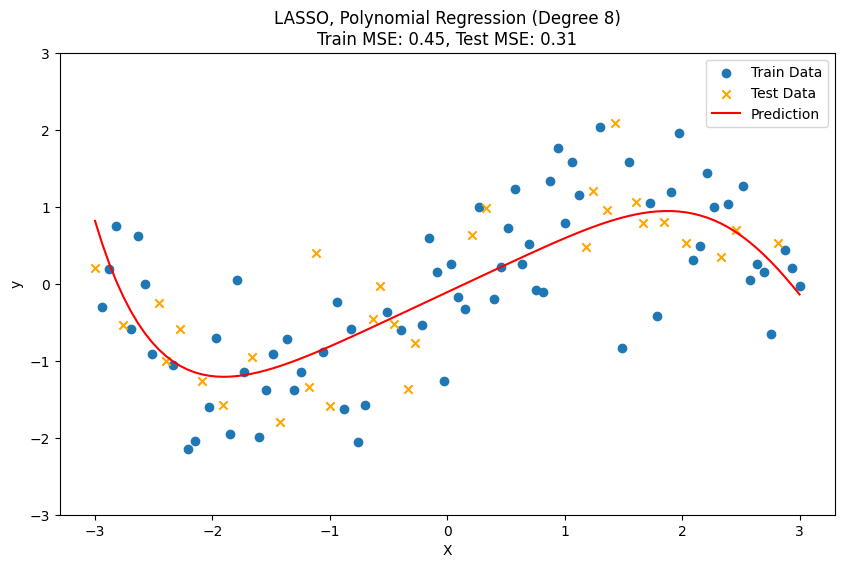

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.957e+01, tolerance: 7.739e-03
  model = cd_fast.enet_coordinate_descent(


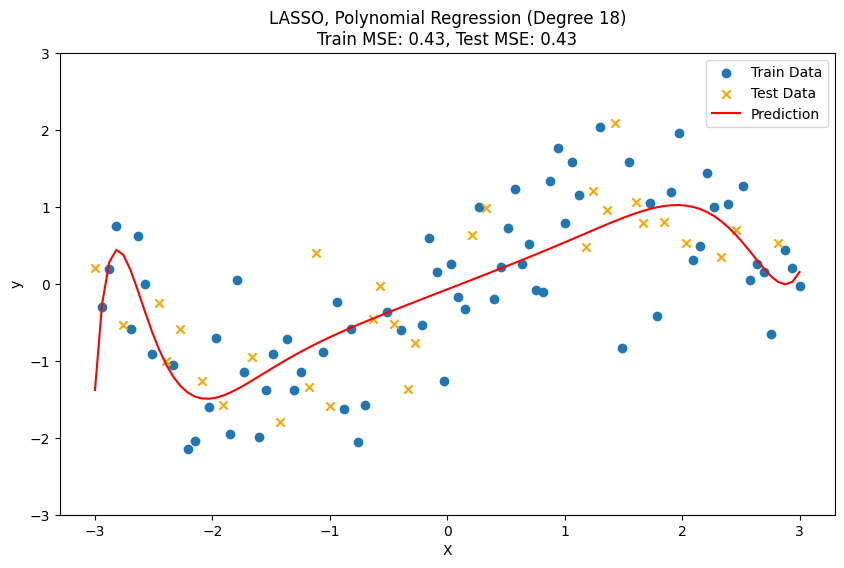

In [69]:
from sklearn.linear_model import Lasso
degrees = [8, 18]
lasso_reg = Lasso(alpha=0.1)  # Adjust alpha as needed
title = "LASSO, Polynomial Regression"
fit_polynomial(lasso_reg, degrees, title)

# 5. Hyperparameter search

*   <font color='blue'>**Question:**</font> Given a model with one or more hyperparameters (or several competing models), how do we choose the best one?

In ML, data is typically divided into three subsets: the training set, the validation set, and the test set.

*   The **training set** is used to train the model.
*   The **validation set** is used to tune hyperparameters and select the best model.
*   The **test set** is used for a final evaluation of the model's performance.


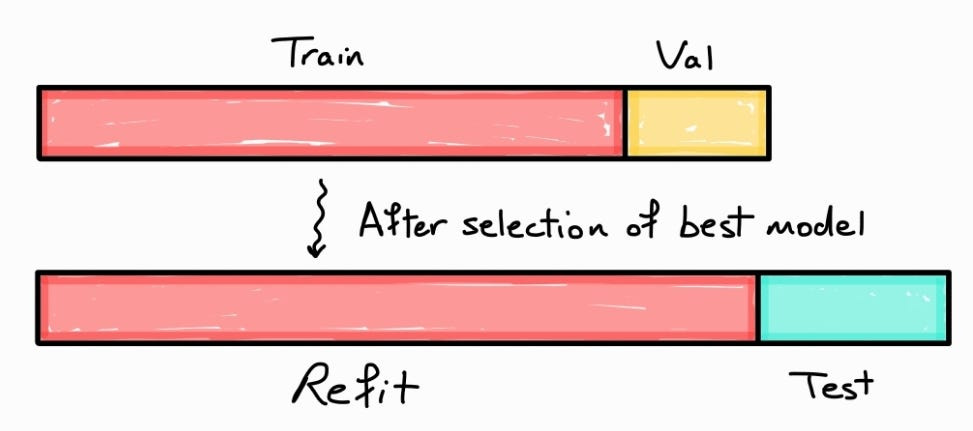

In [70]:
# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) # 80% train, 20% val

# Define the range of alpha values to test
alphas = np.logspace(-4, 2, 100)

best_alpha = None
min_mse = float('inf')

for alpha in alphas:
  lasso = Lasso(alpha=alpha)
  lasso.fit(X_train, y_train)
  y_pred_val = lasso.predict(X_val)
  mse_val = mean_squared_error(y_val, y_pred_val)

  if mse_val < min_mse:
    min_mse = mse_val
    best_alpha = alpha

print(f"Best alpha: {best_alpha}")
print(f"Minimum MSE on validation set: {min_mse}")

Best alpha: 0.0001
Minimum MSE on validation set: 0.5979265416846282


Let's draw predictions of the best model

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+01, tolerance: 8.500e-03
  model = cd_fast.enet_coordinate_descent(


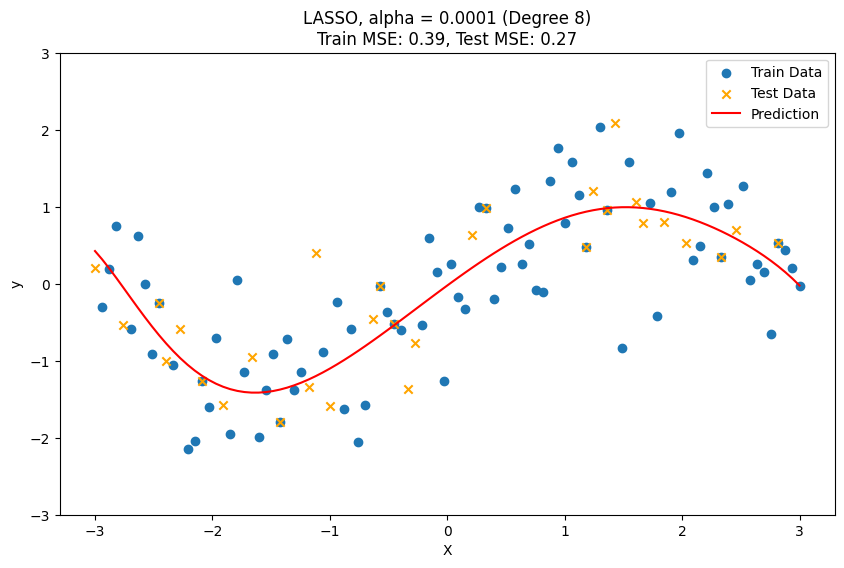

In [71]:
degrees = [8]
lasso_reg = Lasso(alpha=best_alpha)
title = f"LASSO, alpha = {best_alpha}"
fit_polynomial(lasso_reg, degrees, title)

## 5.1 K-fold cross-validation

Two standard strategies for finding optimal hyperparameters are:

*   **[GridSearch](https://scikit-learn.org/1.6/modules/generated/sklearn.model_selection.GridSearchCV.html):** Explores all possible combinations of hyperparameters  within a predefined grid.
* **[RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html):** Randomly samples hyperparameter combinations for efficient exploration.



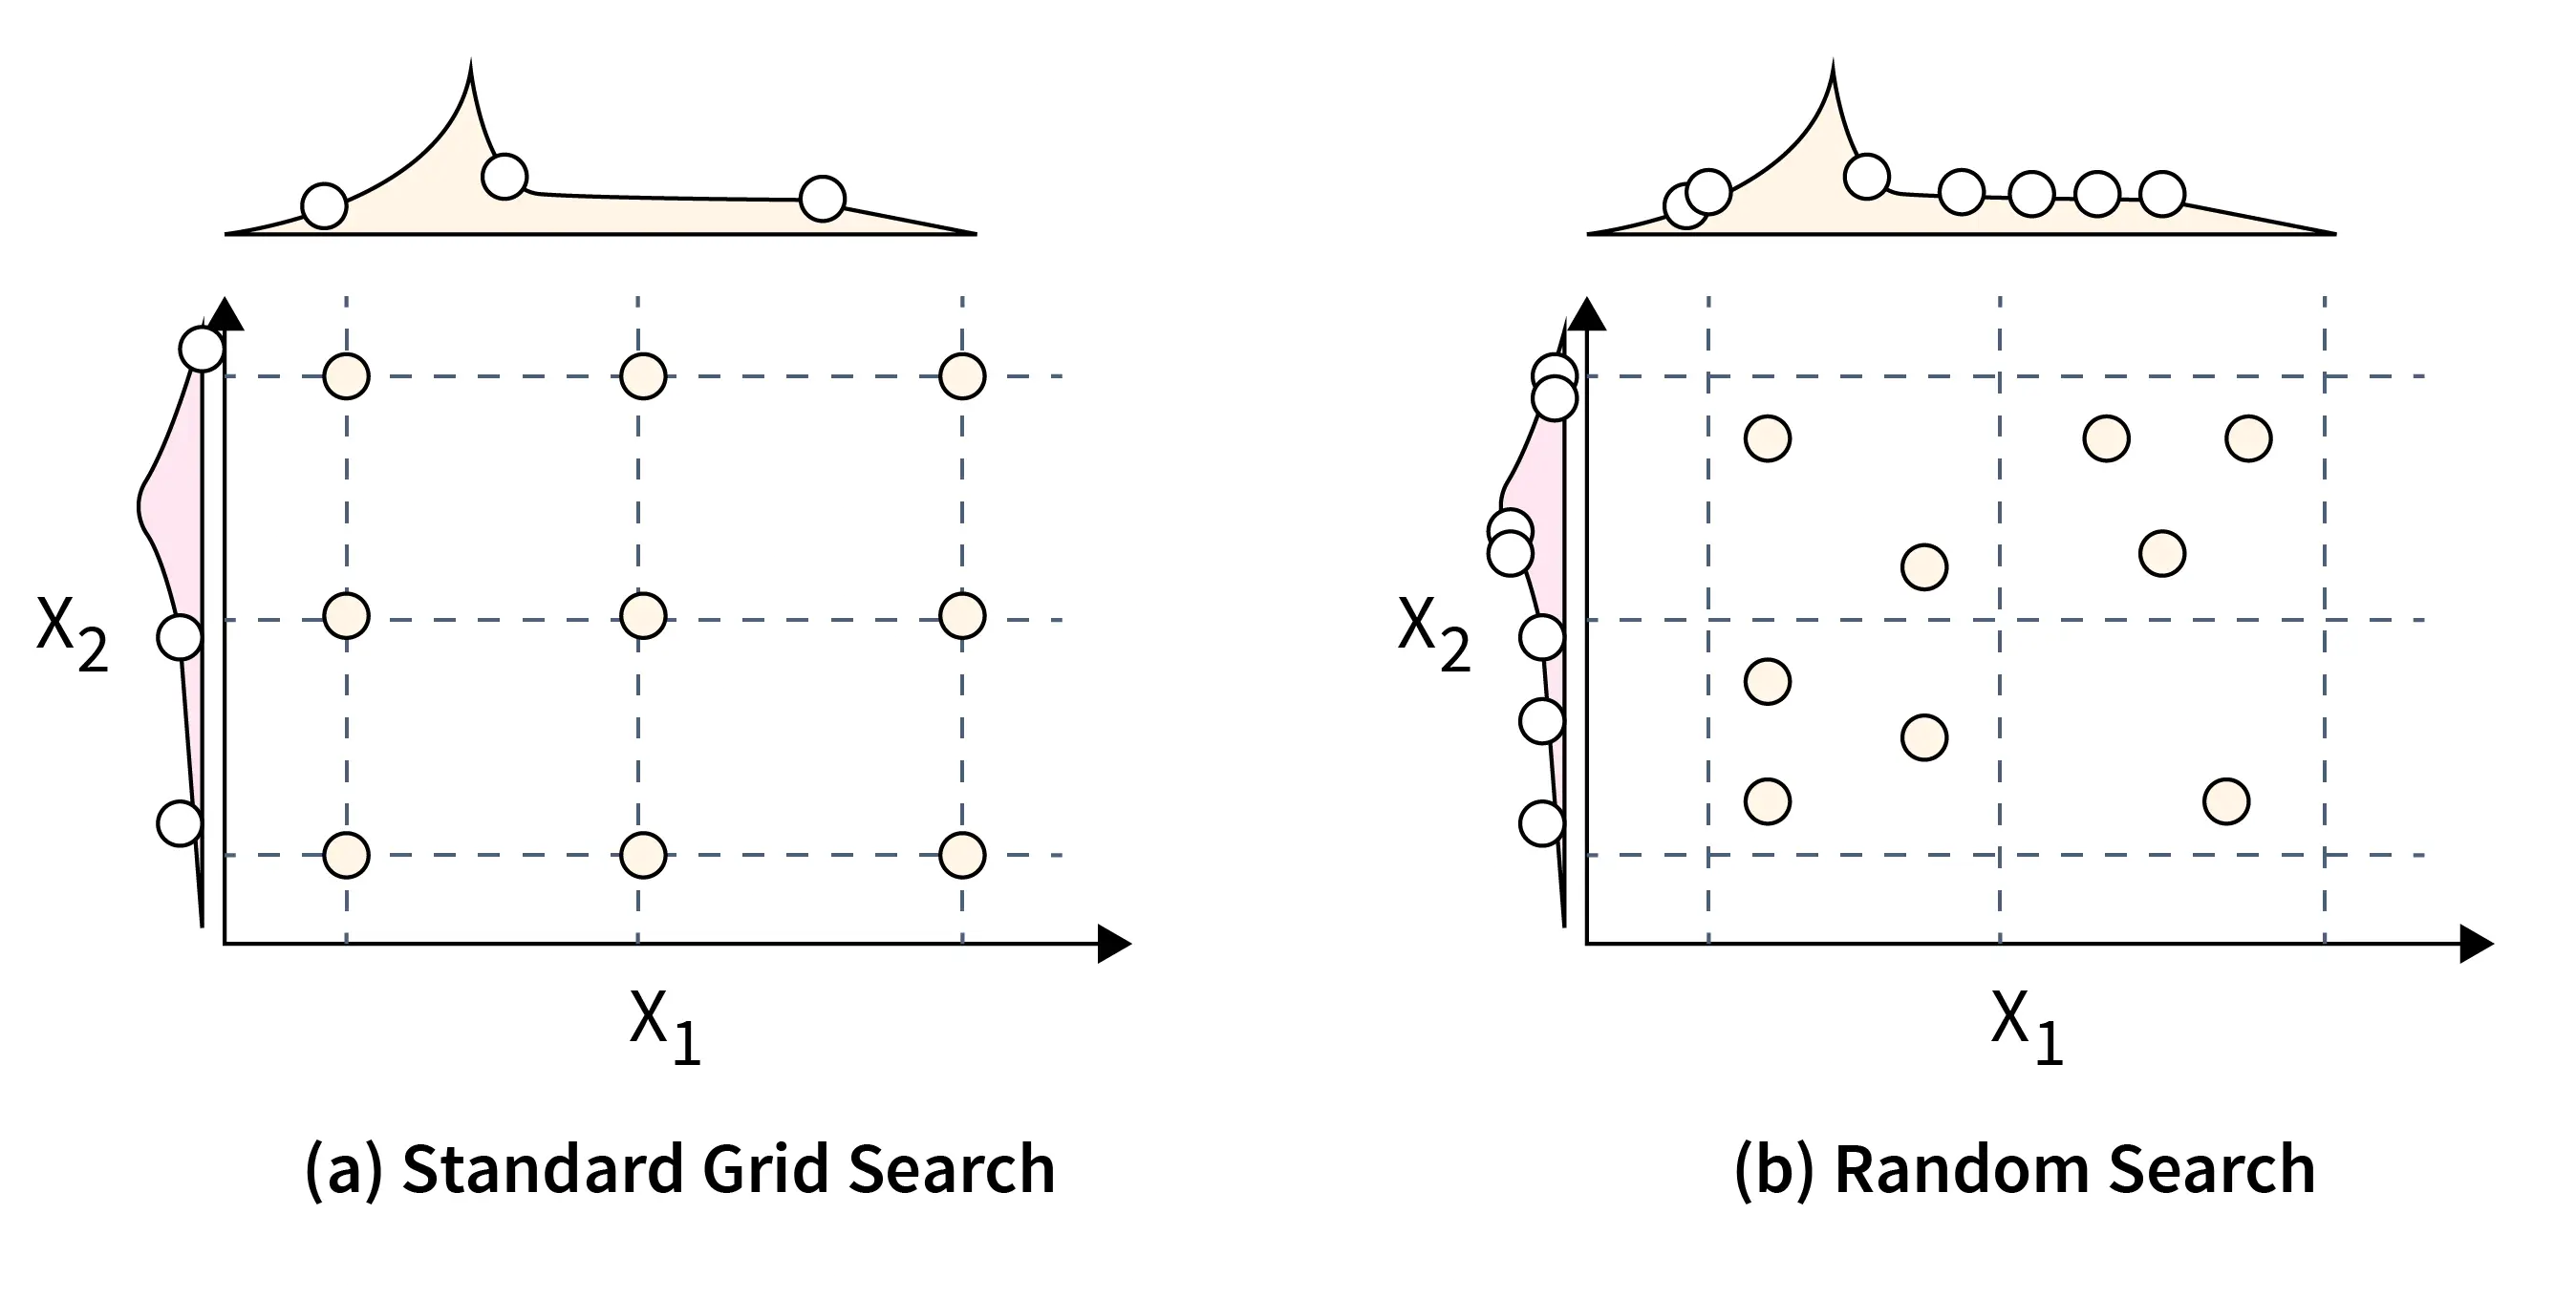

 The choice of the validation set can impact the selected hyperparameters.  To mitigate this effect, we can employ techniques like **[K-fold cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)**:

*   The training data is divided into k subsets (folds).
*   We train the model k times, each time holding out one fold as a validation set and training on the remaining k-1 folds.
*   The average performance across the k validation sets gives us a reliable estimate of how well the model generalizes to unseen data.

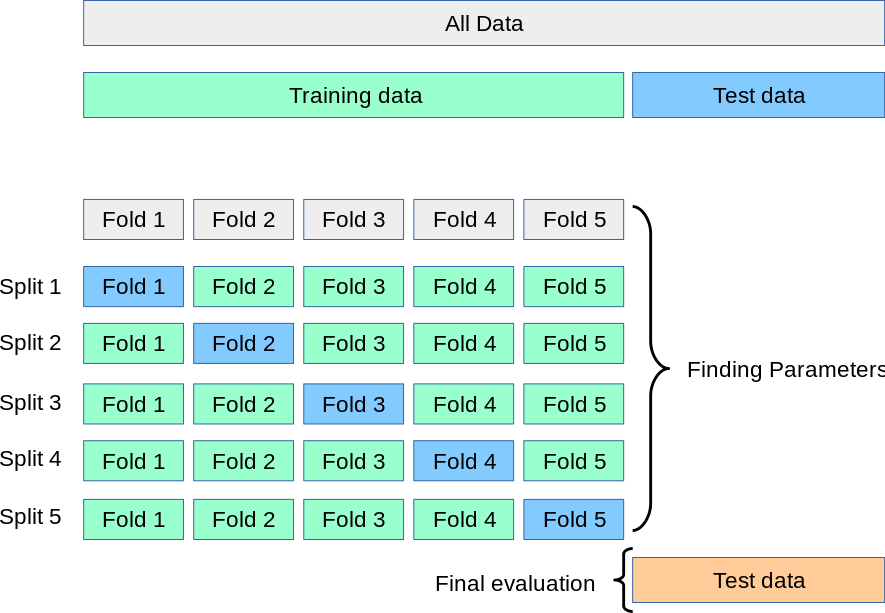

In [72]:
from sklearn.model_selection import KFold

def find_alpha(alphas, k):
    # Initialize KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    best_alpha = None
    min_mse = float('inf')
    for alpha in alphas:
        mse_values = []
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            lasso = Lasso(alpha=alpha)
            lasso.fit(X_train, y_train)
            y_pred = lasso.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            mse_values.append(mse)

        avg_mse = np.mean(mse_values)

        if avg_mse < min_mse:
            min_mse = avg_mse
            best_alpha = alpha
    return best_alpha, min_mse


# Define the range of alpha values to test
alphas = np.logspace(-4, 2, 100)
# Number of folds for cross-validation
k = 5
best_alpha, min_mse = find_alpha(alphas, k)
print(f"Best alpha: {best_alpha}")
print(f"Minimum MSE: {min_mse}")

Best alpha: 0.0001
Minimum MSE: 0.6919452747178825


# 6. Quadratic equations

We will generate two datasets of quadratic equations $x^2 +px +q$ with real roots:
      
1. By sampling coefficients $p$ and $q$ uniformly from the interval $(-10, 10)$ and restricting the sampling to the region $p^2 - 4q \geq 0$.

2. By sampling two roots $a$ and $b$ uniformly from the interval $(-10, 10)$ and constructing the corresponding quadratic equation $(x-a)(x-b)$.
     

In [73]:
def generate_quadratic_data(n_samples, limit_coef=1.0, limit_root=1.0):
    # Method 1: Sampling coefficients p, q
    p_values_1 = []
    q_values_1 = []
    roots_1 = []
    while len(p_values_1) < n_samples:
        p = np.random.uniform(-limit_coef, limit_coef)
        q = np.random.uniform(-limit_coef, limit_coef)
        if p**2 - 4 * q >= 0:
            root1 = (-p + np.sqrt(p**2 - 4 * q)) / 2
            root2 = (-p - np.sqrt(p**2 - 4 * q)) / 2
            p_values_1.append(p)
            q_values_1.append(q)
            roots_1.append(max(root1, root2))

    # Method 2: Sampling roots a, b
    a_values = np.random.uniform(-limit_root, limit_root, n_samples)
    b_values = np.random.uniform(-limit_root, limit_root, n_samples)
    roots_2 = np.maximum(a_values, b_values)

    p_values_2 = -(a_values + b_values)
    q_values_2 = a_values * b_values

    data1 = pd.DataFrame({'p': p_values_1, 'q': q_values_1, 'y': roots_1})
    data2 = pd.DataFrame({'p': p_values_2, 'q': q_values_2, 'y': roots_2})

    return data1, data2

# Example usage:
n_samples = 1000
limit_coef, limit_root = 10.0, 10.0
data1, data2 = generate_quadratic_data(n_samples, limit_coef, limit_root)
print(data1.shape, data2.shape)

(1000, 3) (1000, 3)


Let's visualize the distributions of $p$ and $q$ for each dataset.


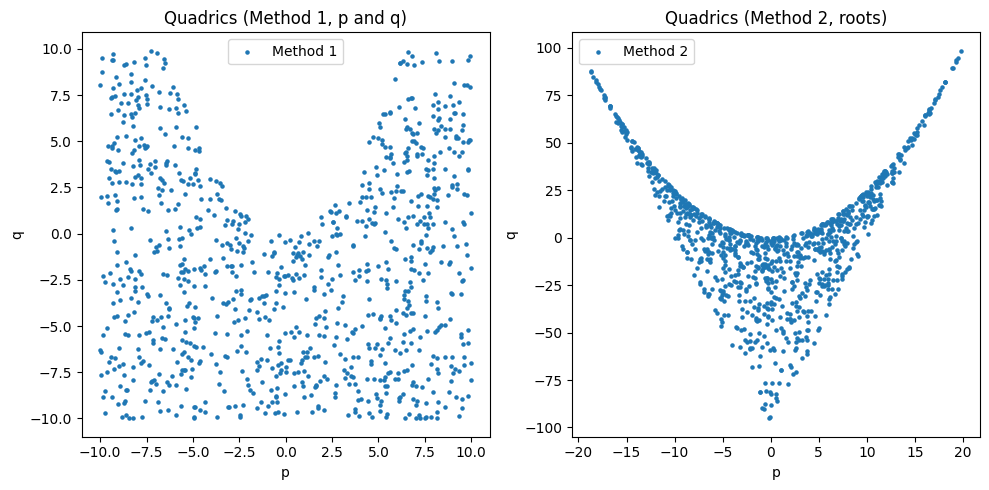

In [74]:
# Plot the datasets
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(data1['p'], data1['q'], s=5, label='Method 1')
plt.xlabel('p')
plt.ylabel('q')
plt.title('Quadrics (Method 1, p and q)')
plt.legend()
plt.xlim(auto=True)
plt.ylim(auto=True)
#plt.xlim(-limit_coef - 0.1, limit_coef + 0.1)
#plt.ylim(-limit_coef - 0.1, limit_coef + 0.1)


plt.subplot(1, 2, 2)
plt.scatter(data2['p'], data2['q'], s=5, label='Method 2')
plt.xlabel('p')
plt.ylabel('q')
plt.title('Quadrics (Method 2, roots)')
plt.legend()
plt.xlim(auto=True)
plt.ylim(auto=True)
#plt.xlim(-limit_coef - 0.1, limit_coef + 0.1)
#plt.ylim(-limit_coef - 0.1, limit_coef + 0.1)

plt.tight_layout()
plt.show()

## 6.1 First Dataset: sampled coefficients $p$ and $q$

Polynomial Regression Function:

In [75]:
from sklearn.preprocessing import PolynomialFeatures

def polynomial_regression(df, degree=10):
    X, y = df.values[:, :-1], df.values[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% train, 20% val

    train_losses = []
    test_losses = []
    degrees = range(1, degree+1)

    for degree in degrees:
        # Polynomial features
        poly_features = PolynomialFeatures(degree=degree, include_bias=True)
        X_poly_train = poly_features.fit_transform(X_train)
        X_poly_test = poly_features.transform(X_test)
        # Linear Regression model
        lin_reg = LinearRegression()
        lin_reg.fit(X_poly_train, y_train)

        # Predictions and MSE calculation
        y_train_pred = lin_reg.predict(X_poly_train)
        y_test_pred = lin_reg.predict(X_poly_test)

        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)

        train_losses.append(train_mse)
        test_losses.append(test_mse)

    # Best model
    best_degree = np.argmin(test_losses) + 1
    return np.array(train_losses), np.array(test_losses), best_degree

Determine the Best Model:

Best model: degree = 12
Train Loss: 0.00029755461116082773
Test Loss: 0.00038030794580531496


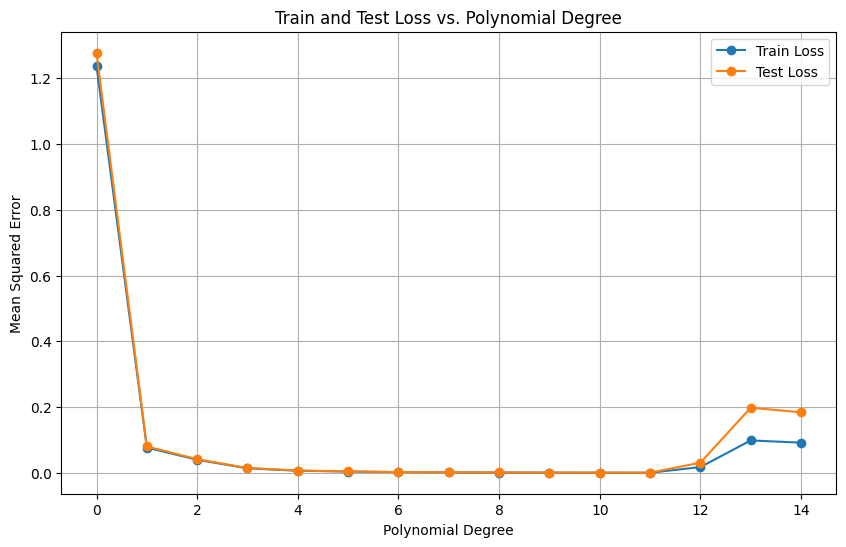

In [76]:
def plot_predictions(train_losses, test_losses, degrees):
    plt.figure(figsize=(10, 6))
    plt.plot(degrees, train_losses, label="Train Loss", marker='o', linestyle='-')
    plt.plot(degrees, test_losses, label="Test Loss", marker='o', linestyle='-')
    plt.xlabel("Polynomial Degree")
    plt.ylabel("Mean Squared Error")
    plt.title("Train and Test Loss vs. Polynomial Degree")
    plt.legend()
    plt.grid(True)
    plt.show()

def find_best_model(df, degree=15):
    train_losses, test_losses, best_degree = polynomial_regression(df, degree)
    print(f"Best model: degree = {best_degree}")
    print(f"Train Loss: {train_losses[best_degree-1]}")
    print(f"Test Loss: {test_losses[best_degree-1]}")
    degrees = range(degree)
    plot_predictions(train_losses, test_losses, degrees)
    return best_degree

best_degree1 = find_best_model(df=data1, degree=15)

Visualizing predictions and the real labels:

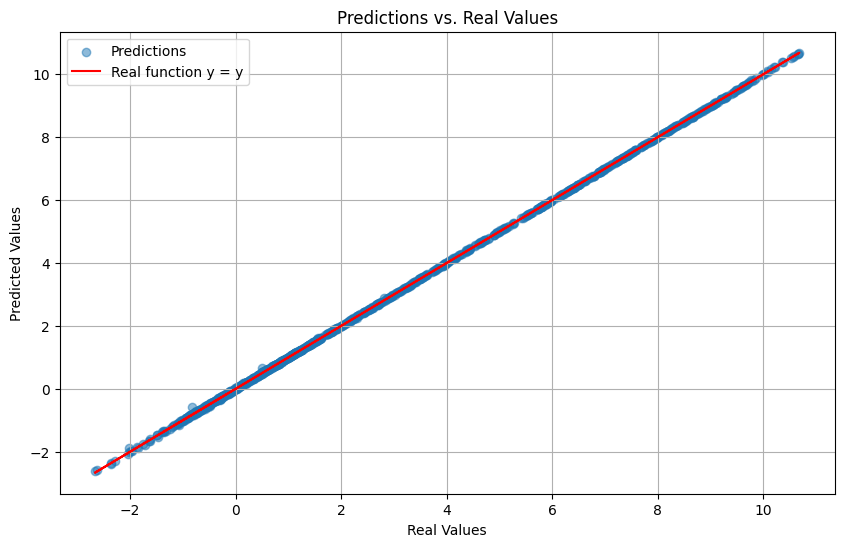

In [77]:
def plot_predictions_true(df, best_degree):
    X = df[['p', 'q']].values
    y_true = df['y'].values
    model = LinearRegression()
    poly_features = PolynomialFeatures(degree=best_degree, include_bias=True)
    X_poly = poly_features.fit_transform(X)
    model.fit(X_poly, y_true)
    y_pred = model.predict(PolynomialFeatures(degree=best_degree).fit_transform(X))

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, label="Predictions", alpha = 0.5)
    plt.plot(y_true, y_true, color="red", label="Real function y = y") # Plot the real function
    plt.xlabel("Real Values")
    plt.ylabel("Predicted Values")
    plt.title("Predictions vs. Real Values")
    plt.legend()
    plt.grid(True)
    plt.show()

    return y_pred, model

y_pred1, model1 = plot_predictions_true(df=data1, best_degree=best_degree1)

We plot the predicted roots against the true roots, calculated as $$y = \frac{1}{2}\left(-p + \sqrt{p^2 - 4q}\right).$$ The results demonstrate that our model effectively predicts the true roots for the given dataset.

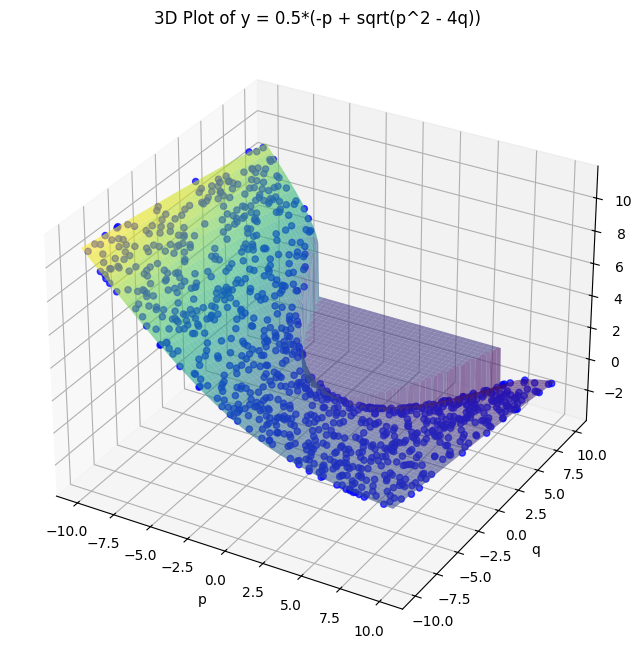

In [78]:
def plot_3D_prediction(df, y_pred, window_size=10):
    # Create a grid of points in the square [-P, P] x [-P, P]
    p = np.linspace(-window_size, window_size, 400)
    q = np.linspace(-window_size, window_size, 400)
    P, Q = np.meshgrid(p, q)

    # Calculate y for each point in the grid
    # Handle potential errors due to negative values under the square root
    Y = np.zeros_like(P)
    valid_points = (P**2 - 4 * Q) >= 0
    Y[valid_points] = 0.5 * (-P[valid_points] + np.sqrt(P[valid_points]**2 - 4 * Q[valid_points]))

    # Create the plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(P, Q, Y, cmap='viridis', alpha=0.6)

    # Plot the model's predictions
    ax.scatter(df['p'], df['q'], y_pred, label="Predictions", alpha=0.7, color='blue')


    ax.set_xlabel('p')
    ax.set_ylabel('q')
    ax.set_zlabel('y')
    ax.set_title('3D Plot of y = 0.5*(-p + sqrt(p^2 - 4q))')

    plt.show()


plot_3D_prediction(data1, y_pred1)

However, predicting outside the range of the training data can lead to significant errors.

This is often a consequence of **overfitting**, particularly when using high-degree polynomials.

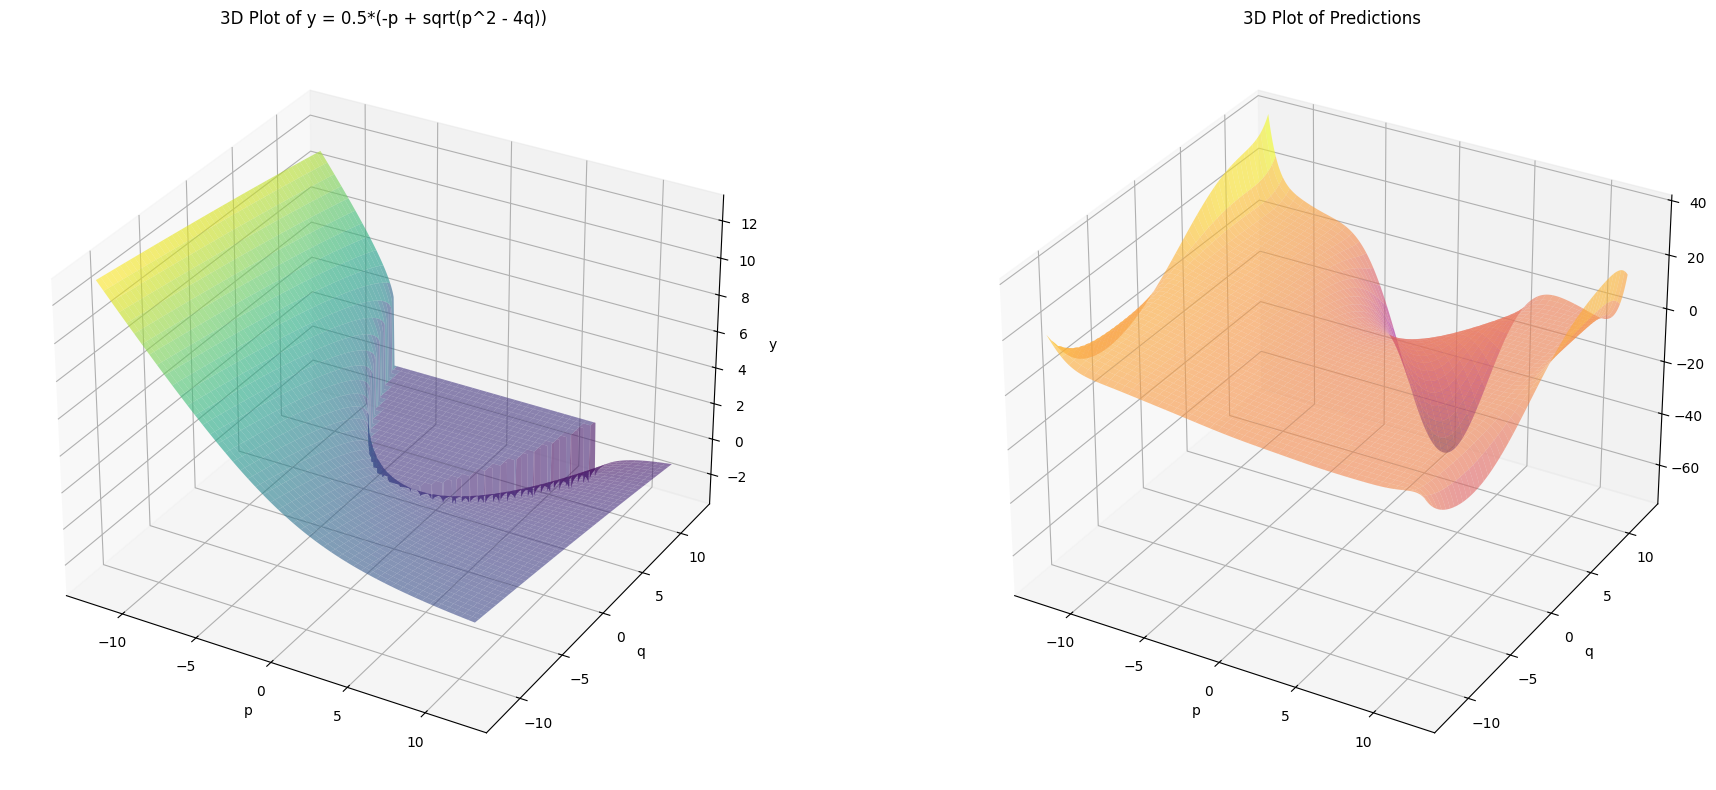

In [79]:
def draw_extension(data, model, best_degree, window_size = 10):
    # Create a grid of points in the square [- window_size,  window_size] x [- window_size,  window_size]
    p = np.linspace(- window_size, window_size, 400)
    q = np.linspace(- window_size,  window_size, 400)
    P, Q = np.meshgrid(p, q)

    X_grid = np.vstack((P.flatten(), Q.flatten())).T
    y_pred_extra = model.predict(PolynomialFeatures(degree=best_degree).fit_transform(X_grid))
    y_pred_extra = y_pred_extra.reshape(P.shape)

    # Calculate y for each point in the grid
    # Handle potential errors due to negative values under the square root
    Y = np.zeros_like(P)
    valid_points = (P**2 - 4 * Q) >= 0
    Y[valid_points] = 0.5 * (-P[valid_points] + np.sqrt(P[valid_points]**2 - 4 * Q[valid_points]))

    # Create the plot
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': '3d'}) # Add projection='3d' here

    # First plot (original code)
    axes[0].plot_surface(P, Q, Y, cmap='viridis', alpha=0.6)
    axes[0].set_xlabel('p')
    axes[0].set_ylabel('q')
    axes[0].set_zlabel('y')
    axes[0].set_title('3D Plot of y = 0.5*(-p + sqrt(p^2 - 4q))')


    # Second plot (original code)
    axes[1].plot_surface(P, Q, y_pred_extra, label="Predictions", cmap='plasma', alpha=0.6)
    axes[1].set_xlabel('p')
    axes[1].set_ylabel('q')
    axes[1].set_zlabel('y')
    axes[1].set_title('3D Plot of Predictions')


    plt.tight_layout()
    plt.show()

draw_extension(data1, model1, best_degree1, 1.1*(1 + limit_coef))

We can analyze the coefficients of the model:

In [80]:
def print_first_coefficients(model):
  coefficients = model.coef_
  intercept = model.intercept_

  print("Intercept:", intercept)
  print("Linear coefficients:", coefficients[1:3]) # Linear terms (assuming p and q are the features)
  print("Quadratic coefficients:", coefficients[3:6]) # Quadratic terms
  print("Cubic coefficients:", coefficients[6:10]) # Cubic terms

print_first_coefficients(model1)

Intercept: 0.41521969789416824
Linear coefficients: [-0.50691987 -0.6582982 ]
Quadratic coefficients: [ 0.15615105 -0.00552802 -0.10176044]
Cubic coefficients: [ 0.00101569  0.04528403 -0.00120792 -0.01128759]


We can investigate the low-degree polynomial fits to our data.

In [81]:
def get_best_polynomial_model(df, max_degree=2):
    max_num_terms = int((max_degree + 1) * (max_degree + 2) / 2)
    # Create a list to store data for the DataFrame
    data = []

    for degree in range(max_degree+1):
        poly_features = PolynomialFeatures(degree=degree, include_bias=True)
        X_poly = poly_features.fit_transform(df[['p','q']])
        model = LinearRegression()
        model.fit(X_poly, data1['y'])
        coefficients = model.coef_
        intercept = model.intercept_
        row = list(coefficients)
        row[0] = intercept
        while len(row) < max_num_terms:
            row.append(0)
        data.append(row)

    # Create a list of polynomial terms
    terms = []
    for i in range(degree + 1):
        for j in range(i + 1):
            if i == 0:
                terms.append("1")
            elif j == 0:
                terms.append(f"x^{i}")
            elif i == j:
                terms.append(f"y^{i}")
            else:
                terms.append(f"x^{i-j}y^{j}")

    # Create the Pandas DataFrame
    df = pd.DataFrame(data, columns=terms)
    display(df)

get_best_polynomial_model(data1, max_degree=3)

1       x^1       y^1       x^2    x^1y^1       y^2       x^3  \
0  3.051093  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  3.006088 -0.498733 -0.091587  0.000000  0.000000  0.000000  0.000000   
2  1.376319 -0.499678 -0.156589  0.038502 -0.000315  0.000396  0.000000   
3  1.219816 -0.496816 -0.230668  0.042233 -0.000233 -0.002553 -0.000032   

     x^2y^1    x^1y^2       y^3  
0  0.000000  0.000000  0.000000  
1  0.000000  0.000000  0.000000  
2  0.000000  0.000000  0.000000  
3  0.001435 -0.000038 -0.000031

## 6.2 Second Dataset: sampled roots $a$ and $b$

For the second dataset, we obtain a different optimal model.

Best model: degree = 6
Train Loss: 0.010743730093625241
Test Loss: 0.00950158608151164


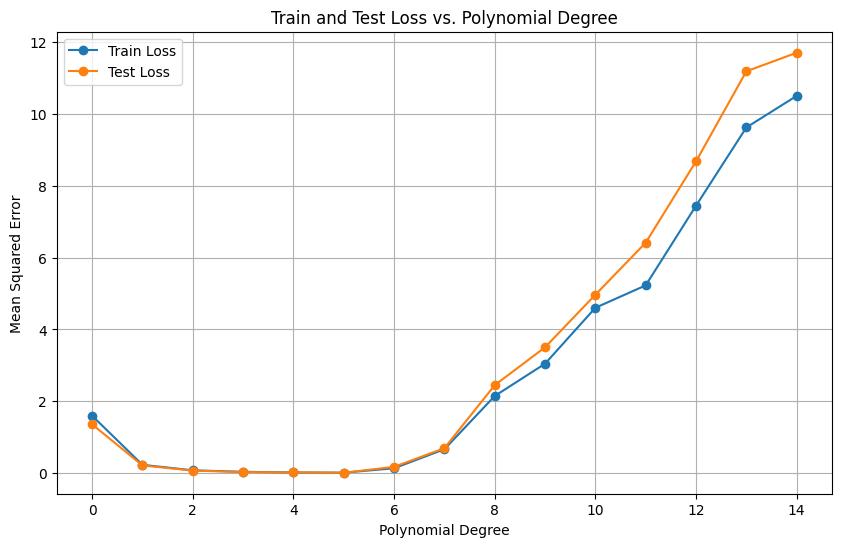

In [82]:
best_degree2 = find_best_model(df=data2, degree=15)

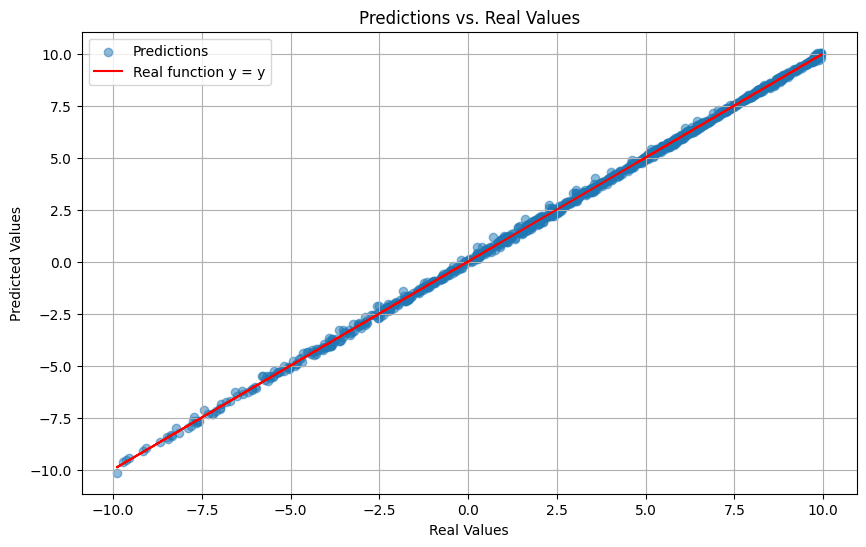

In [83]:
y_pred2, model2 = plot_predictions_true(df=data2, best_degree=best_degree2)

Within the range of the observed data, our predictions are quite good.

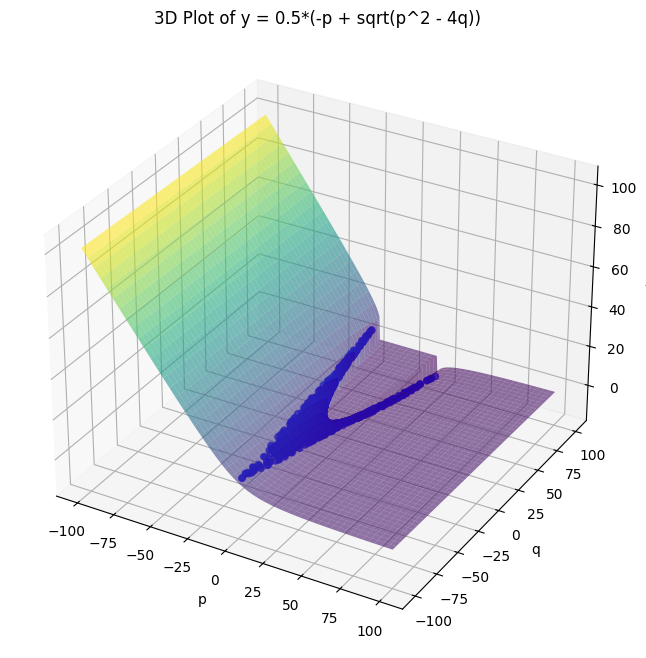

In [84]:
plot_3D_prediction(data2, y_pred2, window_size=100)

Extrapolation beyond the data range leads to significant errors.

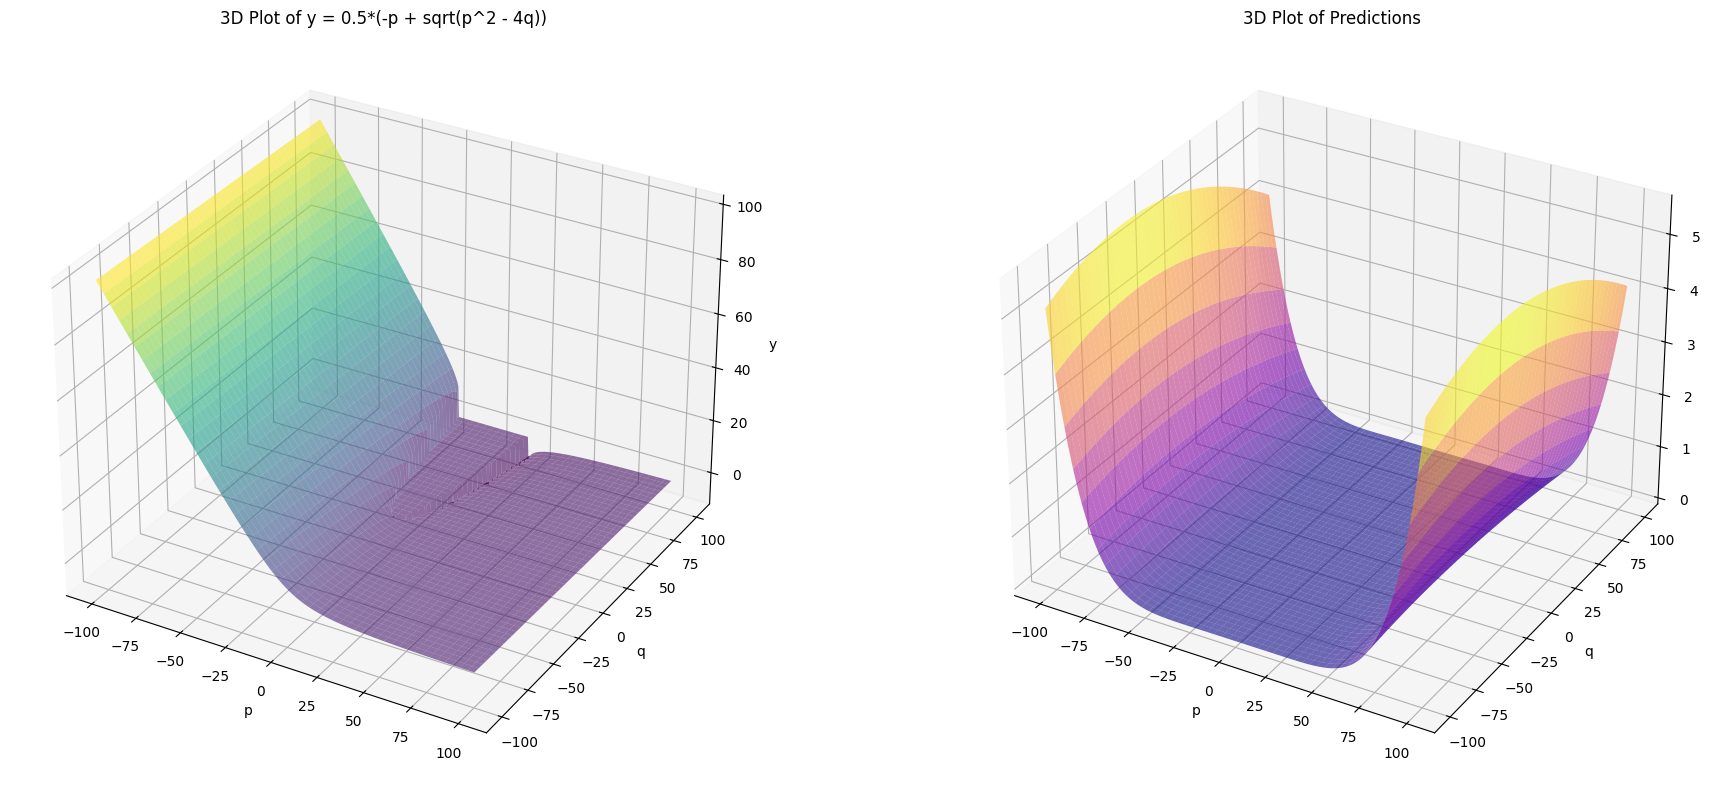

In [85]:
draw_extension(data2, model2, best_degree2, window_size = 100)

Specific model coefficients:

In [86]:
print_first_coefficients(model2)

Intercept: 0.4653052256072301
Linear coefficients: [-0.49003491 -0.40467786]
Quadratic coefficients: [ 0.10742453  0.00040634 -0.0175196 ]
Cubic coefficients: [-3.19332948e-04  8.11992717e-03  1.74463846e-06 -4.93965315e-04]


We can investigate the low-degree polynomial fits to our data.

In [87]:
get_best_polynomial_model(data2, max_degree=3)

1       x^1       y^1       x^2    x^1y^1       y^2       x^3  \
0  3.051093  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  3.051880 -0.005379 -0.000620  0.000000  0.000000  0.000000  0.000000   
2  3.332793  0.002043  0.008477 -0.004332 -0.000207  0.000001  0.000000   
3  3.320523 -0.068420 -0.004456 -0.004262 -0.002331 -0.000702  0.001163   

    x^2y^1    x^1y^2       y^3  
0  0.00000  0.000000  0.000000  
1  0.00000  0.000000  0.000000  
2  0.00000  0.000000  0.000000  
3  0.00036 -0.000021 -0.000008